# Initialization

In [1]:
COUNTRIES = [
'AU', 'AT', 'BE', 'CA', 'CZ', 'DK', 'FI', 'FR', 'DE', 'GB', 
'IT', 'JP', 'NL', 'PL', 'PT', 'SK', 'ES', 'SE', 'CH', 'US']

In [2]:
!python --version
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

Python 3.12.10


In [3]:
import json,sys,os

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely as sh
import matplotlib.pyplot as plt

import requests

import folium
from folium.plugins import MarkerCluster
from IPython.display import HTML,Image

from requests_ratelimiter import LimiterSession
session = LimiterSession(per_second=1)
session.headers.update({'User-Agent': 'safeweb','email':'safeweb@vut.cz'})

from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

from joblib import Memory
os.makedirs('__cache', exist_ok=True)
memory = Memory(location=f'__cache',verbose=0)

# Functions

In [4]:
@memory.cache
def REST_API_GET(url):

    result = pd.NA
    
    try:        
        result = session.get(url=url)
    except:
        print('REST API connection error.')
        raise SystemExit
    
    return result

In [5]:
@memory.cache
def WEB_VALID(url):

    result = False
    
    url = 'https://'+url
    
    try:
        response = requests.head(url, timeout=10, allow_redirects=True)
        if response.status_code == 200: result = True
    except:
        None

    return result

In [6]:
tlds = ['com', 'org', 'net', 'info', 'biz', 'name', 'pro',
        'app', 'blog', 'cloud', 'dev', 'ai', 'io', 'xyz', 
        'online', 'shop', 'store',  'edu', 'gov', 'mil', 
        'int', 'museum', 'aero', 'jobs']

In [7]:
def parse_website(url):

    result = pd.NA

    if pd.isna(url) or url == '' : return pd.NA

    # wrong openstreetmap records
    url = url.lower()
    url = url.replace('"','')
    url = url.split(';')[0]
    
    url = url.removeprefix('https://')
    url = url.removeprefix('http://')
    url = url.removeprefix('https')
    url = url.removeprefix('http')
    url = url.removeprefix('//')    
    url = url.removeprefix('wwww.')
    url = url.split('/')[0]
    website = '.'.join(url.split('.')[-2:])

    # tld in 2nd-level
    test = website.split('.')
                  
    # pre-check for major websites
    if len(website) > 1 and len(test) == 2 and not test[-2] in tlds and not test[-1].isnumeric() and len(test[-2]) >= 10:         

        result = website
    
    return result

In [8]:
def country_to_area(country):
    
    area_id = pd.NA

    url = f'https://nominatim.openstreetmap.org/search?country={country}&format=json'
    
    response = REST_API_GET(url)
    
    if pd.notna(response) and response.status_code == 200:
        
        try:
            response_data = json.loads(response.text)
            
            # find first relation record
            for record in response_data:    
                if record['osm_type'] == 'relation':
                    area_id = record['osm_id'] + 3600000000; break
        except:
            print('REST API data error.')
            raise SystemExit
            
    else:      
        print('REST API request error.')
        raise SystemExit

    return area_id

In [9]:
def get_country_urls(area):

    urls = []

    query = f'''[out:json][timeout:1200];
    area({area}) -> .country;
    (
      nw['website'](area.country);
    );
    out center;'''
    
    #url = f'https://overpass-api.de/api/interpreter?data={query}'
    url = f'https://overpass.kumi.systems/api/interpreter?data={query}'
    
    response = REST_API_GET(url)
    
    if pd.notna(response) and response.status_code == 200:
        try:
            response_data = response.json()['elements']

            for item in response_data:
                if item['type'] == 'node': 
                    urls.append(['node',item['tags']['website'],item['lat'],item['lon'],item['tags']])
                else:
                    urls.append(['way',item['tags']['website'],item['center']['lat'],item['center']['lon'],item['tags']])
                    
        except:
            print('REST API data error.')
            raise SystemExit
    else:
        print('REST API request error.')
        raise SystemExit
   
    if len(urls) == 0: urls = pd.NA

    return urls

In [10]:
facility_type = pd.read_csv('curration-defs/facility.txt', header=None,names=['text'])
facility_type.text = facility_type.text.str.lower()
facility_type = facility_type.sort_values(by='text')

content = "; ".join(facility_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/facility_table.txt', 'w') as f:
    f.write(content)

facility_type.text.to_csv(f'curration-defs/facility.txt', index=False, header=False)

facility_type

text
0        aerodrome
1       alpine_hut
2      alternative
3        alzheimer
4      alzheimer's
..             ...
261     water_park
262    weighbridge
263  winter_sports
264           yoga
265            zoo

[266 rows x 1 columns]

In [11]:
commerce_type = pd.read_csv('curration-defs/commerce.txt', header=None,names=['text'])
commerce_type.text = commerce_type.text.str.lower()
commerce_type = commerce_type.sort_values(by='text')

commerce_type.text.to_csv(f'curration-defs/commerce.txt', index=False, header=False)

content = "; ".join(commerce_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/commerce_table.txt', 'w') as f:
    f.write(content)

commerce_type

text
0            accountant
1    advertising_agency
2              agrarian
3               airsoft
4               alcohol
..                  ...
197           wholesale
198                wine
199              winery
200               works
201            workshop

[202 rows x 1 columns]

In [12]:
forbidden_type = pd.read_csv('curration-defs/forbidden.txt', header=None,names=['text'])
forbidden_type.text = forbidden_type.text.str.lower()
forbidden_type = forbidden_type.sort_values(by='text')

content = "; ".join(forbidden_type.text.astype(str).str.replace('_', r'\_'))
with open('curration-defs/forbidden_table.txt', 'w') as f:
    f.write(content)

forbidden_type.text.to_csv(f'curration-defs/forbidden.txt', index=False, header=False)

forbidden_type

text
0   adult_gaming_centre
1               brothel
2                casino
3                erotic
4                  fake
5              gambling
6         hookah_lounge
7            love_hotel
8             nightclub
9          prostitution
10              sexshop
11            stripclub
12          swingerclub

In [13]:
facility_dict = {key:'Facility' for key in facility_type.text}
commerce_dict = {key:'Commerce' for key in commerce_type.text}
forbidden_dict = {key:'Forbidden' for key in forbidden_type.text}
text_cat = {**facility_dict,**commerce_dict,**forbidden_dict}

text_cat

{'aerodrome': 'Facility',
 'alpine_hut': 'Facility',
 'alternative': 'Facility',
 'alzheimer': 'Facility',
 "alzheimer's": 'Facility',
 'amusement_arcade': 'Facility',
 'animal_boarding': 'Facility',
 'animal_breeding': 'Facility',
 'animal_shelter': 'Facility',
 'animal_training': 'Facility',
 'apartment': 'Facility',
 'archive': 'Facility',
 'art_school': 'Facility',
 'arts_centre': 'Facility',
 'atelier': 'Facility',
 'atm': 'Facility',
 'attraction': 'Facility',
 'audiologist': 'Facility',
 'baby_hatch': 'Facility',
 'bank': 'Facility',
 'bar': 'Facility',
 'bbq': 'Facility',
 'beauty': 'Facility',
 'bench': 'Facility',
 'bicycle_library': 'Facility',
 'bicycle_parking': 'Facility',
 'bicycle_rental': 'Facility',
 'bicycle_repair_station': 'Facility',
 'bicycle_wash': 'Facility',
 'biergarten': 'Facility',
 'blood_bank': 'Facility',
 'bmx': 'Facility',
 'bowling_alley': 'Facility',
 'bowls': 'Facility',
 'bureau_de_change': 'Facility',
 'bus_station': 'Facility',
 'cafe': 'Facility

In [14]:
def get_tag_text(tags,tag):
    
    result = pd.NA
    
    tag_text = tags.get(tag,pd.NA)    
    if tag_text is pd.NA: tag_text = tags.get('disused:'+tag,pd.NA)
    if tag_text is pd.NA: tag_text = tags.get('was:'+tag,pd.NA)  
    if tag_text is pd.NA: tag_text = tags.get('speciality:'+tag,pd.NA)

    if tag_text is not pd.NA: tag_text.lower()
        
    result = tag_text
    
    return result

In [15]:
def get_place_type(tags):

    tag_types = [
        'amenity', 'shop', 'healthcare', 'craft', 'tourism', 
        'leisure', 'landuse', 'man_made', 'place', 'industrial',
        'sport', 'club', 'denomination', 'office', 'cuisine',
        'building', 'waterway', 'aeroway'
    ]
    
    for tag in tag_types:
        tag_text = get_tag_text(tags=tags, tag=tag)
        if tag_text is not pd.NA:
            result = text_cat.get(tag_text.lower(), pd.NA)
            if result is not pd.NA:
                return result
    
    yes_mapping = {
        'office': 'Commerce',
        'shop': 'Commerce',
        'club': 'Facility',
        'healthcare': 'Facility'
    }
    
    for tag, value in yes_mapping.items():
        tag_text = get_tag_text(tags=tags, tag=tag)
        if tag_text is not pd.NA and tag_text == 'yes':
            return value
    
    # check for key presence
    commerce_keys = ['workshop', 'parcelshop', 'operator', 'payment:american_express',
                    'payment:cash', 'payment:checks', 'payment:discover_card',
                    'payment:mastercard', 'payment:visa', 'payment:credit_cards',
                    'payment:debit_cards', 'fuel']
    if any(key in tags for key in commerce_keys):
        return 'Commerce'
    
    facility_keys = ['attraction', 'boundary', 'camera', 'cemetery', 'crop',
                    'emergency', 'highway', 'historic', 'military', 'natural',
                    'parking', 'population', 'public_transport', 'railway',
                    'road', 'route', 'telecom', 'polling_station', 'company',
                    'industrial', 'power', 'construction', 'telecom', 'religion','emergency']
    if any(key in tags for key in facility_keys):
        return 'Facility'

    # here we check for text matching
    forbidden_keys = ['adult_gaming_centre', 'brothel', 'casino', 'erotic',
                     'gambling', 'hookah', 'love', 'nightclub', 'prostitution',
                     'sexshop', 'stripclub', 'swingerclub']
    if any(key in tags for key in forbidden_keys):
        return 'Forbidden'
    
    return 'Unknown'

In [16]:
def frame_info(frame,mem=False,dtype=False,sample=False,n=5,width=50,columns=50):

    size = len(frame)

    if mem: 
        print(round(frame.memory_usage(deep=True)/(1024**3),1).to_string())
        print('Total ',round(frame.memory_usage(deep=True).sum()/(1024**3),1))

    if dtype:
        print()
        print(frame.dtypes.to_string())     

    if sample:
        print(size)
        frame = frame.sample(min(n,size))

    with pd.option_context('display.min_rows', n, 'display.max_rows', n,
                           'display.max_columns', columns,'display.max_colwidth', width):
        display(frame)

    return

# Main

In [17]:
data = pd.DataFrame(COUNTRIES,columns = ['country'])
data.country = data.country.astype('category')

data['area'] = data.country.progress_apply(country_to_area)
data.area = data.area.astype('category')

data['urls'] = data.progress_apply(lambda r: get_country_urls(r.area),axis=1)
data.pop('area')

data = data.explode('urls',ignore_index=True).rename(columns = {'urls':'url'})
data[['osm','url','lat','lon','tags']] = pd.DataFrame(data.url.tolist(), index=data.index)

data.osm = data.osm.astype('category')
data.url = data.url.str.lower()
data.url = data.url.astype(pd.StringDtype('pyarrow'))
data.lat = data.lat.astype(pd.StringDtype('pyarrow'))
data.lon = data.lon.astype(pd.StringDtype('pyarrow'))

data = data.sample(frac=1)

frame_info(data,dtype=True)

100%|███████████████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.38it/s]

country           category
url        string[pyarrow]
osm               category
lat        string[pyarrow]
lon        string[pyarrow]
tags                object


country                                                url   osm  \
79931        AT            https://www.cafegrillpizzamemo-wien.at/  node   
678159       DE                 https://www.robinsschreibshop.com/  node   
...         ...                                                ...   ...   
954579       DE  https://www.dortmund.de/de/freizeit_und_kultur...  node   
2108739      CH                            https://nfh.ch/st-jakob  node   

                lat         lon  \
79931     48.174658  16.3669804   
678159    48.221771  11.6669738   
...             ...         ...   
954579   51.5145913   7.4672691   
2108739  46.9059841   8.5213073   

                                                      tags  
79931    {'addr:city': 'Wien', 'addr:country': 'AT', 'a...  
678159   {'addr:city': 'Ismaning', 'addr:country': 'DE'...  
...                                                    ...  
954579   {'historic': 'memorial', 'inscription': '"Geg....  
2108739  {'addr:city': 'Isenthal', 'addr:postcode': '64...  

[2916062 rows x 6 columns]

In [18]:
data['website'] = data.url.progress_apply(parse_website)
data.pop('url')
todrop = data.loc[data.website.isna()]
print(len(todrop))
data = data.drop(todrop.index)
data.website = data.website.astype(pd.StringDtype('pyarrow'))

100%|████████████████████████████████████████████████| 2916062/2916062 [00:02<00:00, 1024018.00it/s]
1372871


In [19]:
website_counts = data.website.value_counts()
todrop = website_counts[website_counts > 1].index
todrop = data.loc[data.website.isin(todrop)]
print(len(todrop))
data = data.drop(todrop.index)

frame_info(data,dtype=True)

643901

country           category
osm               category
lat        string[pyarrow]
lon        string[pyarrow]
tags                object
website    string[pyarrow]


country   osm         lat         lon  \
79931        AT  node   48.174658  16.3669804   
678159       DE  node   48.221771  11.6669738   
...         ...   ...         ...         ...   
1085736      DE   way   47.820497   8.9730315   
1154328      DE   way  51.9280311   9.2036099   

                                                      tags  \
79931    {'addr:city': 'Wien', 'addr:country': 'AT', 'a...   
678159   {'addr:city': 'Ismaning', 'addr:country': 'DE'...   
...                                                    ...   
1085736  {'amenity': 'school', 'name': 'Freie Waldorfsc...   
1154328  {'addr:city': 'Lügde', 'addr:housenumber': '1'...   

                            website  
79931    cafegrillpizzamemo-wien.at  
678159        robinsschreibshop.com  
...                             ...  
1085736   waldorfschule-wahlwies.de  
1154328  bildungsschule-harzberg.de  

[899290 rows x 6 columns]

In [20]:
data['place_type'] = data.tags.progress_apply(get_place_type)
data.place_type = data.place_type.astype('category')

frame_info(data,mem=True,sample=True,n=10)

100%|███████████████████████████████████████████████████| 899290/899290 [00:01<00:00, 603822.31it/s]
Index         0.0
country       0.0
osm           0.0
lat           0.0
lon           0.0
tags          0.3
website       0.0
place_type    0.0
Total  0.4
899290


country   osm         lat          lon  \
1199118      DE   way  49.9294143    9.0673108   
2338422      US  node  34.7558955  -86.7336191   
299573       CA   way   43.355224  -80.3185235   
363599       DK  node   55.046831     10.67102   
2485206      US  node  33.1705985  -96.8039666   
1469693      IT  node  42.5509068   12.4225491   
2577773      US   way  40.9458741   -90.362661   
1401675      GB   way  51.4474938   -0.3267022   
1469042      IT  node  45.6718505    9.0853043   
2409117      US  node  61.2138743  -149.908209   

                                                      tags  \
1199118  {'addr:city': 'Großostheim', 'addr:housenumber...   
2338422  {'addr:city': 'Madison', 'addr:housenumber': '...   
299573   {'name': 'The Gaslight District', 'place': 'ci...   
363599   {'amenity': 'events_venue', 'fvst:navnelbnr': ...   
2485206  {'addr:housenumber': '11201', 'addr:street': '...   
1469693  {'addr:city': 'Amelia', 'addr:housenumber': '1...   
2577773  {'addr:city': 'Galesburg', 'addr:housenumber':...   
1401675  {'addr:city': 'Twickenham', 'addr:housenumber'...   
1469042  {'addr:city': 'Lazzate', 'addr:housenumber': '...   
2409117  {'addr:city': 'Anchorage', 'addr:country': 'US...   

                            website place_type  
1199118       zieger-landtechnik.de    Unknown  
2338422    bamafever-tigerpride.com   Commerce  
299573          gaslightdistrict.ca    Unknown  
363599        skipperkroen-thuro.dk   Facility  
2485206  friscoemergencypetcare.com   Commerce  
1469693          artphotoevaluna.it   Commerce  
2577773          discoverydepot.org   Facility  
1401675  ricemillthairestaurant.com   Facility  
1469042             edilproposte.it   Commerce  
2409117       delaneyparkdental.com   Facility

In [21]:
data['website_valid'] = data.website.progress_apply(WEB_VALID)

todrop = data.loc[data.website_valid != True]
print(len(todrop))
data = data.drop(todrop.index)
data.pop('website_valid')

frame_info(data,mem=True,sample=True,n=10)

100%|████████████████████████████████████████████████████| 899290/899290 [00:43<00:00, 20886.35it/s]
321145
Index         0.0
country       0.0
osm           0.0
lat           0.0
lon           0.0
tags          0.2
website       0.0
place_type    0.0
Total  0.2
578145


country   osm         lat           lon  \
2513540      US  node  32.3471212   -97.3838418   
2581337      US   way   39.999528  -105.2274938   
957967       DE  node  52.2784311     8.0856792   
608061       FR   way   48.387017    -4.4860312   
884526       DE  node  48.0608058     8.5473972   
2066817      SE   way  62.5280045    17.4423844   
1500062      IT  node  40.3573722    18.1874188   
1161347      DE   way  50.7751228     8.3001205   
327974       CZ  node  49.8315743    13.9051319   
795937       DE  node  53.6207122     9.6734275   

                                                      tags  \
2513540  {'artist_name': 'Kristen Soble', 'artwork_type...   
2581337  {'addr:city': 'Boulder', 'addr:housenumber': '...   
957967   {'addr:city': 'Osnabrück', 'addr:housenumber':...   
608061   {'bmo:type': 'D', 'building': 'hotel', 'buildi...   
884526   {'email': 'info@haru-design-cnc.de', 'name': '...   
2066817  {'aeroway': 'aerodrome', 'alt_name': 'Midlanda...   
1500062  {'addr:housenumber': '91c', 'addr:street': 'Vi...   
1161347  {'addr:city': 'Dillenburg', 'addr:housenumber'...   
327974   {'email': 'jelinkova.80@seznam.cz', 'healthcar...   
795937   {'addr:city': 'Holm', 'addr:housenumber': '18'...   

                          website place_type  
2513540          kristensoble.com   Commerce  
2581337            sbcboulder.com   Facility  
957967   pinguin-textilpflege.com   Commerce  
608061             kelig-hotel.fr   Facility  
884526         haru-design-cnc.de   Commerce  
2066817             sdlairport.se   Facility  
1500062           sudcomputers.it    Unknown  
1161347         ev-frohnhausen.de   Facility  
327974        wellnessdrazovka.cz    Unknown  
795937              weinfriese.de   Commerce

# Tests

In [22]:
data.loc[data.website.isna()]

Empty DataFrame
Columns: [country, osm, lat, lon, tags, website, place_type]
Index: []

In [23]:
data.loc[data.lat.isna()]

Empty DataFrame
Columns: [country, osm, lat, lon, tags, website, place_type]
Index: []

In [24]:
data.loc[data.place_type.isna()]

Empty DataFrame
Columns: [country, osm, lat, lon, tags, website, place_type]
Index: []

# Reports

In [25]:
data.loc[data.place_type == 'Facility'].sample(10)

country   osm         lat           lon  \
1492234      IT  node  45.4931786    12.1078154   
1083205      DE   way  54.3249021    10.6639451   
260628       CA  node  49.2779922  -123.1096968   
2082373      CH  node  47.4923173      7.592887   
131438       AT   way  46.8127399    12.7643884   
2477748      US  node  40.8153704   -73.9577427   
565211       FR  node  45.9476654     -0.517677   
2342606      US  node  44.9464018   -93.1168932   
1435527      IT  node  45.0679153     7.6959646   
2535672      US   way  38.1594567  -122.4575539   

                                                      tags  \
1492234  {'addr:city': 'Mirano', 'addr:housenumber': '2...   
1083205  {'addr:city': 'Hohwacht', 'addr:country': 'DE'...   
260628   {'addr:city': 'Vancouver', 'addr:housenumber':...   
2082373  {'addr:housename': 'Cucina-amici Pizzaria', 'a...   
131438   {'addr:city': 'Amlach', 'addr:housenumber': '2...   
2477748  {'addr:city': 'New York', 'addr:housenumber': ...   
565211   {'addr:city': 'Saint-Jean-d'Angély', 'addr:cou...   
2342606  {'addr:city': 'Saint Paul', 'addr:housenumber'...   
1435527  {'addr:city': 'Torino', 'addr:country': 'IT', ...   
2535672  {'leisure': 'stadium', 'name': 'Sonoma Raceway...   

                     website place_type  
1492234      villatessier.it   Facility  
1083205  hotel-hausammeer.de   Facility  
260628       thesportsbar.ca   Facility  
2082373      cucina-amici.ch   Facility  
131438        amlacherhof.at   Facility  
2477748  cityprimehealth.com   Facility  
565211    valsdesaintonge.fr   Facility  
2342606     yumisushibar.com   Facility  
1435527   scugnizzotorino.it   Facility  
2535672       racesonoma.com   Facility

In [26]:
data.loc[data.place_type == 'Commerce'].sample(10)

country   osm         lat          lon  \
1026846      DE  node  48.9167689   11.8723848   
2432463      US  node  37.5640493  -77.4591012   
981856       DE  node   49.794044    9.9327779   
2145896      US  node  29.6607655  -95.2383172   
1143654      DE   way  50.7661185    8.8954283   
2345959      US  node  38.2809733  -76.4947409   
2775886      US   way  40.7363527  -73.9597529   
972789       DE  node   52.497428   13.3240406   
1490566      IT  node  44.5316254   11.3536027   
1197520      DE   way  51.9458777    7.6363727   

                                                      tags  \
1026846  {'addr:city': 'Kelheim', 'addr:country': 'DE',...   
2432463  {'addr:city': 'Richmond City', 'addr:housenumb...   
981856   {'addr:city': 'Würzburg', 'addr:country': 'DE'...   
2145896  {'addr:city': 'South Houston', 'addr:housenumb...   
1143654  {'addr:city': 'Amöneburg', 'addr:country': 'DE...   
2345959  {'addr:city': 'Great Mills', 'addr:housenumber...   
2775886  {'addr:housenumber': '2', 'addr:postcode': '11...   
972789   {'addr:housenumber': '48', 'addr:street': 'Uhl...   
1490566  {'addr:housenumber': '187/2b', 'addr:postcode'...   
1197520  {'addr:city': 'Münster', 'addr:country': 'DE',...   

                          website place_type  
1026846            awo-kelheim.de   Commerce  
2432463  kindredspiritbrewing.com   Commerce  
981856    kulturwerk-schlesien.de   Commerce  
2145896       lealfuneralhome.com   Commerce  
1143654       ried-landtechnik.de   Commerce  
2345959          stoppingmold.com   Commerce  
2775886           twoblueslip.com   Commerce  
972789    tierarzt-baerenwiese.de   Commerce  
1490566           timbrilampo.com   Commerce  
1197520        businessdock-ms.de   Commerce

In [27]:
data.loc[data.place_type == 'Unknown'].sample(10)

country   osm         lat          lon  \
1497651      IT  node  45.5478769   10.1650391   
2728623      US   way  38.8846863  -77.0979594   
910269       DE  node  47.7560049   11.3811453   
2026927      ES   way   41.369975     1.158777   
1017139      DE  node  51.4924729   11.9657675   
661209       FR   way  48.2526388    7.4370845   
1654074      NL  node  51.8038468    4.7042403   
2130732      CH   way  47.3040173    8.7673583   
597742       FR  node  42.4127345    8.6475005   
1036842      DE   way  50.1388604    8.7035627   

                                                      tags  \
1497651  {'craft': 'restoration', 'name': 'D.p.m.', 'we...   
2728623  {'addr:city': 'Arlington', 'addr:housenumber':...   
910269   {'craft': 'metal_construction', 'email': 'info...   
2026927  {'building': 'yes', 'name': 'Celler Mas Forast...   
1017139  {'addr:city': 'Halle (Saale)', 'addr:country':...   
661209   {'building': 'yes', 'name': 'Habitat Services'...   
1654074  {'addr:city': 'Dordrecht', 'addr:housenumber':...   
2130732  {'addr:city': 'Gossau ZH', 'addr:housenumber':...   
597742   {'name': 'La Boutique Wish', 'shop': 'boutique...   
1036842  {'email': 'schriftfuehrer@kgv-cronberger.de', ...   

                             website place_type  
1497651               dpmbrescia.com    Unknown  
2728623            arlbeergarden.com    Unknown  
910269           balser-metallbau.de    Unknown  
2026927            josepforaster.com    Unknown  
1017139      buerger-fuer-buerger.de    Unknown  
661209          habitat-services.org    Unknown  
1654074        vanderjagtuitvaart.nl    Unknown  
2130732                cevigossau.ch    Unknown  
597742            laboutiquewish.com    Unknown  
1036842  kleingaertner-cronberger.de    Unknown

In [28]:
data.loc[data.place_type == 'Forbidden'].sample(10)

country   osm         lat           lon  \
1877614      PL   way   52.353902     21.131163   
971012       DE  node  50.2840102     9.1082358   
1584141      JP  node  35.7296839   139.7162331   
753226       DE  node  48.4379716    10.9266649   
2102162      CH  node  47.3716888     8.5398052   
2118783      CH  node  47.2813684     7.7183793   
248624       CA  node   49.281207  -123.0154316   
2742399      US   way  38.5252469  -118.6239423   
2051488      SE  node  59.8611473    17.6354543   
1706902      NL  node  51.9008108     4.4977299   

                                                      tags  \
1877614  {'addr:city': 'Marki', 'addr:city:simc': '0920...   
971012   {'leisure': 'adult_gaming_centre', 'name': 'Sp...   
1584141  {'addr:block_number': '28', 'addr:city': '東京都'...   
753226   {'addr:city': 'Affing', 'addr:country': 'DE', ...   
2102162  {'amenity': 'nightclub', 'check_date': '2024-0...   
2118783  {'addr:housenumber': '34d', 'addr:street': 'Dü...   
248624   {'addr:housenumber': '4027', 'addr:street': 'H...   
2742399  {'addr:city': 'Hawthorne', 'addr:housenumber':...   
2051488  {'addr:city': 'Uppsala', 'addr:country': 'SE',...   
1706902  {'addr:city': 'Rotterdam', 'addr:housenumber':...   

                           website place_type  
1877614           euphoria-club.pl  Forbidden  
971012   spielpyramiden-casinos.de  Forbidden  
1584141            vivienne-ikb.jp  Forbidden  
753226            club-sttropez.de  Forbidden  
2102162            widderhotel.com  Forbidden  
2118783              kleinparis.ch  Forbidden  
248624              bulalounge.com  Forbidden  
2742399            elcapcasino.com  Forbidden  
2051488              lustgarden.se  Forbidden  
1706902         climaxrotterdam.nl  Forbidden

# Samples

In [29]:
data.drop_duplicates(subset='country')

country   osm          lat           lon  \
79931        AT  node    48.174658    16.3669804   
1418337      GB   way   50.8151998    -0.3517396   
1840300      PL   way   50.2067749    19.7760567   
662203       FR   way   46.8095813    -2.1200379   
871024       DE  node   50.8544885    12.7804252   
2461409      US  node   33.5657203  -111.9245442   
2120435      CH  node   47.5406518     9.1840953   
308153       CZ  node   50.2496881    17.2180097   
1643583      NL  node   52.1900583     5.9413463   
184817       BE   way   51.2176312      4.411335   
2017097      ES   way   40.3310803    -3.7831812   
1514337      IT   way   45.5687407    11.4665315   
231536       CA  node   46.1400335   -73.7349325   
2055506      SE  node   64.6179329    21.1994544   
402375       FI  node   60.2786688    25.0189569   
1610387      JP   way    38.718068   139.8277543   
374547       DK  node   55.6960947    12.5458652   
37401        AU   way  -38.1494697    144.362957   
1899624      PT  node   38.7429403    -9.1784246   
1955783      SK   way   47.9179395    18.1134882   

                                                      tags  \
79931    {'addr:city': 'Wien', 'addr:country': 'AT', 'a...   
1418337  {'building': 'yes', 'leisure': 'escape_game', ...   
1840300  {'addr:city': 'Jerzmanowice', 'addr:city:simc'...   
662203   {'access': 'customers', 'addr:housenumber': '1...   
871024   {'addr:city': 'Limbach-Oberfrohna', 'addr:coun...   
2461409  {'addr:city': 'Scottsdale', 'addr:postcode': '...   
2120435  {'addr:city': 'Sulgen', 'addr:housenumber': '1...   
308153   {'addr:city': 'Česká Ves', 'addr:housenumber':...   
1643583  {'addr:city': 'Apeldoorn', 'addr:housenumber':...   
184817   {'addr:city': 'Antwerpen', 'addr:housenumber':...   
2017097  {'addr:housenumber': '21', 'addr:postcode': '2...   
1514337  {'addr:housenumber': '25', 'addr:street': 'Via...   
231536   {'addr:housenumber': '8082', 'addr:street': 'C...   
2055506  {'addr:country': 'SE', 'addr:housenumber': '3B...   
402375   {'addr:city': 'Helsinki', 'addr:housenumber': ...   
1610387  {'addr:block_number': '1', 'addr:city': '鶴岡市',...   
374547   {'fvst:navnelbnr': '807578', 'name': 'Kropsrum...   
37401    {'addr:city': 'Geelong', 'addr:country': 'AU',...   
1899624  {'addr:city': 'Lisboa', 'addr:housenumber': '7...   
1955783  {'contact:email': 'ubytovanie@domcekynesvady.s...   

                            website place_type  
79931    cafegrillpizzamemo-wien.at   Facility  
1418337      escapegameworthing.com   Facility  
1840300           chocholowydwor.pl   Facility  
662203          campinglerivage.com   Facility  
871024   praxis-michalik-richter.de   Facility  
2461409       ritzyragsandshoes.com   Commerce  
2120435               smartfiles.ch   Commerce  
308153                zsceskaves.cz   Facility  
1643583      expodisplayservice.com    Unknown  
184817           stadsfeestzaal.com   Commerce  
2017097         colegioprincipe.com   Facility  
1514337               costigiola.it   Commerce  
231536         chaletslanaudiere.ca   Facility  
2055506             buremathorna.se   Facility  
402375              aukioloajat.com   Commerce  
1610387            shonai-tomoni.jp   Facility  
374547               kropsrummet.dk   Facility  
37401              geelonghotel.com   Facility  
1899624           carloscarrilho.pt   Commerce  
1955783           domcekynesvady.sk   Facility

# Visual

AU
100%|███████████████████████████████████████████████████████| 2306/2306 [00:00<00:00, 213832.35it/s]
AT
100%|█████████████████████████████████████████████████████| 19579/19579 [00:00<00:00, 213499.61it/s]
BE
100%|██████████████████████████████████████████████████████| 14185/14185 [00:00<00:00, 90592.68it/s]
CA
100%|█████████████████████████████████████████████████████| 21429/21429 [00:00<00:00, 241166.18it/s]
CZ
100%|███████████████████████████████████████████████████████| 7877/7877 [00:00<00:00, 212312.16it/s]
DK
100%|███████████████████████████████████████████████████████| 7104/7104 [00:00<00:00, 215114.25it/s]
FI
100%|███████████████████████████████████████████████████████| 6811/6811 [00:00<00:00, 232364.89it/s]
FR
100%|█████████████████████████████████████████████████████| 48598/48598 [00:00<00:00, 160413.94it/s]
DE
100%|███████████████████████████████████████████████████| 171048/171048 [00:01<00:00, 133938.61it/s]
GB
100%|█████████████████████████████████████████████████████| 1

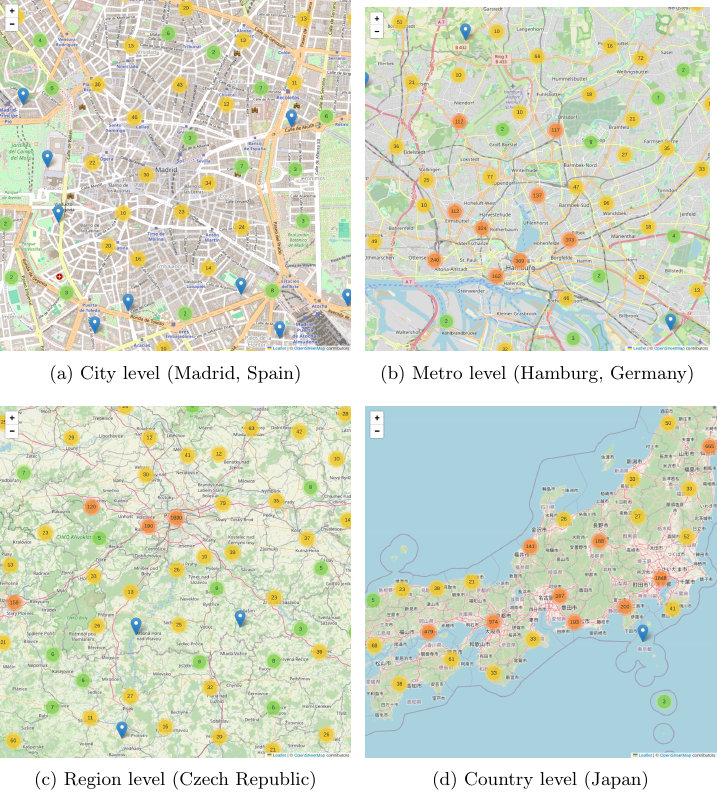

In [30]:
for item in COUNTRIES:
    print(item)

    item_data = data.loc[data.country == item]

    map_fl = folium.Map(zoom_start=13, width=800, height=800)
    marker_cluster = MarkerCluster().add_to(map_fl)
    
    for itemA in tqdm(item_data.itertuples(), total=len(item_data), file=sys.stdout, ncols=100):
        folium.Marker(location=[itemA.lat,itemA.lon]).add_to(marker_cluster)

    map_fl.save(f'result-visual/safeweb-{item}.html')  
    
# sample
#display(HTML(open(f'result-visual/safeweb-{item}.html').read()))
print()
Image('result-visual/example-maps.png')

# Demo

In [31]:
# demo area
lat,lon = [48.158,11.552]
size = 50 #km

In [32]:
data['crd'] = gpd.points_from_xy(data.lon,data.lat)
data = gpd.GeoDataFrame(data)
data.crd = data.crd.set_crs('EPSG:4326')

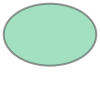

In [33]:
area = sh.Point(lon,lat)
area = gpd.GeoSeries(area).set_crs('EPSG:4326')
area = area.to_crs(area.estimate_utm_crs())
area = area.buffer(size*1000)
area = area.to_crs('EPSG:4326')
area.item()

In [34]:
data_area = data.loc[data.crd.within(area.item())]

data_area

country   osm         lat         lon  \
756334       DE  node  48.0998072  11.5333735   
1024819      DE  node  47.8758016  11.9351569   
898984       DE  node  48.1612621  11.3408451   
857531       DE  node  48.0925196  11.4643871   
747751       DE  node  48.1158013  11.5699277   
...         ...   ...         ...         ...   
683278       DE  node   48.133918  11.6018567   
835786       DE  node  48.5299922  11.5075728   
861171       DE  node  48.0940031  11.5083721   
789893       DE  node  47.9983393  11.3420041   
1201498      DE   way  47.7853296   11.363006   

                                                      tags  \
756334   {'addr:city': 'München', 'addr:country': 'DE',...   
1024819  {'addr:city': 'Bruckmühl', 'addr:country': 'DE...   
898984   {'name': 'Elatek', 'office': 'company', 'websi...   
857531   {'addr:city': 'Neuried', 'addr:housenumber': '...   
747751   {'addr:city': 'München', 'addr:country': 'DE',...   
...                                                    ...   
683278   {'addr:city': 'München', 'addr:country': 'DE',...   
835786   {'female': 'yes', 'male': 'yes', 'name': 'Falk...   
861171   {'addr:city': 'München', 'addr:housenumber': '...   
789893   {'addr:city': 'Starnberg', 'addr:housenumber':...   
1201498  {'emergency': 'lifeguard', 'man_made': 'pier',...   

                                             website place_type  \
756334                               mobileguru24.de    Unknown   
1024819                        sandstrahlen-maier.de   Commerce   
898984                               elatec-rfid.com   Commerce   
857531                                copyneuried.de   Commerce   
747751   caritas-altenheim-st-franziskus-muenchen.de   Facility   
...                                              ...        ...   
683278                             paros-muenchen.de   Facility   
835786                        falkenbergsfriseure.de   Facility   
861171                               erfolgsphoto.de   Commerce   
789893                   starnberger-eiswerkstatt.de   Commerce   
1201498                        wasserwacht-wm-sog.de   Facility   

                               crd  
756334   POINT (11.53337 48.09981)  
1024819  POINT (11.93516 47.87580)  
898984   POINT (11.34085 48.16126)  
857531   POINT (11.46439 48.09252)  
747751   POINT (11.56993 48.11580)  
...                            ...  
683278   POINT (11.60186 48.13392)  
835786   POINT (11.50757 48.52999)  
861171   POINT (11.50837 48.09400)  
789893   POINT (11.34200 47.99834)  
1201498  POINT (11.36301 47.78533)  

[9005 rows x 8 columns]

In [35]:
ax = area.boundary.plot(color='grey',lw = 2)
data_area.crd.plot(ax = ax,marker = '+', color = 'blue',markersize = 100,lw = 0.5)
plt.savefig(f'result-visual/demo-map-area.png',bbox_inches='tight',pad_inches=0.01)

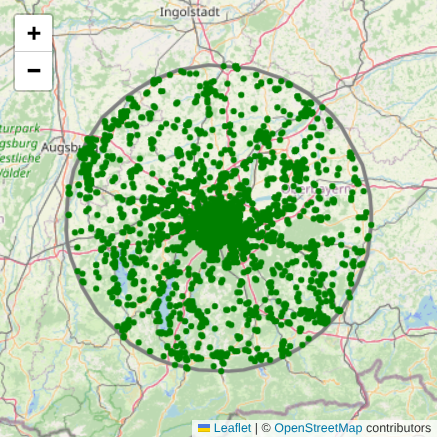

In [36]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)

for item in data_area.loc[data_area.place_type == 'Facility'].itertuples():
    folium.CircleMarker(color='green',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)    

map_fl.save('result-visual/demo-map-facility.html')
#display(HTML(open('result-visual/demo-map-facility.html').read()))
Image('result-visual/demo-map-facility.png')

In [37]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)   

for item in data_area.loc[data_area.place_type == 'Commerce'].itertuples():
    folium.CircleMarker(color='red',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)

map_fl.save('result-visual/demo-map-commerce.html')
#display(HTML(open('result-visual/demo-map-commerce.html').read()))
Image('result-visual/demo-map-commerce.png')

In [38]:
map_fl = folium.Map(location=[lat,lon],zoom_start=8,width=350,height=350)

crds = [(item[1], item[0]) for item in area.item().exterior.coords]
poly_fl = folium.Polygon(locations=crds,color='gray')
poly_fl.add_to(map_fl)   

for item in data_area.loc[data_area.place_type == 'Unknown'].itertuples():
    folium.CircleMarker(color='black',radius=1,
        location=[item.lat,item.lon],
        size=1).add_to(map_fl)

map_fl.save('result-visual/demo-map-unknown.html')
#display(HTML(open('result-visual/demo-map-unknown.html').read()))
Image('result-visual/demo-map-unknown.png')

# Validation

In [39]:
VAL_COUNTRY = 'CZ'

In [40]:
gt_facility = pd.read_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-facility.txt',header=None,names=['website'])
gt_facility['gt_place_type'] = 'Facility'
gt_facility

website gt_place_type
0        2decivinohrady.cz      Facility
1          akcent-hotel.cz      Facility
2          amarorecords.cz      Facility
3        apartmanymaxov.cz      Facility
4    apartmanyustarenky.cz      Facility
..                     ...           ...
423          zskorycany.cz      Facility
424        zsmsprosetin.cz      Facility
425        zsnestemicka.cz      Facility
426         zszeleznice.cz      Facility
427          zuskaplice.cz      Facility

[428 rows x 2 columns]

In [41]:
gt_commerce = pd.read_csv(f'ground-truth/ground-truth-{VAL_COUNTRY}-commerce.txt',header=None,names=['website'])
gt_commerce['gt_place_type'] = 'Commerce'
gt_commerce

website gt_place_type
0           a-z-sekacky.cz      Commerce
1        administratori.cz      Commerce
2        agravelkytynec.cz      Commerce
3         annamaresova.com      Commerce
4          as-superwash.cz      Commerce
..                     ...           ...
124  zelezarstvi-soukup.cz      Commerce
125   zelezarstvikeller.cz      Commerce
126        zlatafontana.cz      Commerce
127     zlatnictvihanys.cz      Commerce
128          zoovedvore.cz      Commerce

[129 rows x 2 columns]

In [42]:
gt = pd.concat([gt_facility,gt_commerce],axis=0)
val = pd.merge(gt, data, how='left', on='website')

val.loc[pd.isna(val.place_type)]
val = val.dropna()
val

website gt_place_type country   osm         lat  \
0        2decivinohrady.cz      Facility      CZ  node  50.0741675   
1          akcent-hotel.cz      Facility      CZ  node  50.0686344   
2          amarorecords.cz      Facility      CZ  node  49.2004847   
3        apartmanymaxov.cz      Facility      CZ  node  50.7623312   
4    apartmanyustarenky.cz      Facility      CZ  node  48.8564965   
..                     ...           ...     ...   ...         ...   
552  zelezarstvi-soukup.cz      Commerce      CZ  node  50.5388604   
553   zelezarstvikeller.cz      Commerce      CZ  node  49.5993767   
554        zlatafontana.cz      Commerce      CZ  node  48.9850257   
555     zlatnictvihanys.cz      Commerce      CZ  node   50.064504   
556          zoovedvore.cz      Commerce      CZ  node   50.075765   

            lon                                               tags place_type  \
0    14.4366952  {'amenity': 'bar', 'contact:facebook': '2deciv...   Facility   
1     14.402821  {'addr:city': 'Praha', 'addr:housenumber': '1/...   Facility   
2    16.6126485  {'addr:city': 'Brno', 'addr:housenumber': '22'...   Facility   
3    15.2190424  {'email': 'michtuma@seznam.cz', 'internet_acce...   Facility   
4     17.028943  {'addr:city': 'Dolní Bojanovice', 'addr:housen...   Facility   
..          ...                                                ...        ...   
552  16.2342271  {'name': 'Železářství Soukup', 'shop': 'hardwa...   Commerce   
553   18.146217  {'addr:city': 'Kopřivnice', 'addr:housenumber'...   Commerce   
554   14.471876  {'addr:city': 'České Budějovice', 'addr:conscr...   Commerce   
555  14.4397978  {'addr:city': 'Praha', 'addr:housenumber': '19...   Commerce   
556   14.403835  {'check_date': '2024-06-19', 'name': 'Zoo Ve D...   Commerce   

                           crd  
0    POINT (14.43670 50.07417)  
1    POINT (14.40282 50.06863)  
2    POINT (16.61265 49.20048)  
3    POINT (15.21904 50.76233)  
4    POINT (17.02894 48.85650)  
..                         ...  
552  POINT (16.23423 50.53886)  
553  POINT (18.14622 49.59938)  
554  POINT (14.47188 48.98503)  
555  POINT (14.43980 50.06450)  
556  POINT (14.40384 50.07576)  

[557 rows x 9 columns]

In [43]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
import seaborn as sns
labels  = ['Facility', 'Commerce', 'Unknown']
cm = confusion_matrix(val.gt_place_type, val.place_type, labels=labels)

ConfusionMatrixDisplay(cm,display_labels=labels).plot(colorbar=False,cmap='Blues_r')

plt.xlabel('Categorized')
plt.ylabel('Ground truth')
plt.savefig(f'result-visual/confusion-matrix-{VAL_COUNTRY}.pdf',bbox_inches='tight',pad_inches=0)
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(val.gt_place_type, val.place_type, labels=['Facility','Commerce']))

              precision    recall  f1-score   support

    Facility       0.98      0.99      0.98       428
    Commerce       0.98      0.95      0.96       129

   micro avg       0.98      0.98      0.98       557
   macro avg       0.98      0.97      0.97       557
weighted avg       0.98      0.98      0.98       557



# Export

In [45]:
# clean data
todrop = data.loc[data.place_type == 'Forbidden']
print(len(todrop))
data = data.drop(todrop.index)

data.pop('tags');data.pop('osm');data.pop('crd');

1948


In [46]:
for item in COUNTRIES:
    item_data = data.loc[data.country == item]
    item_data.to_parquet(f'result-method/safeweb-{item}.parquet',index=False)
    item_data.to_csv(f'result-method/safeweb-{item}.csv',index=False)

frame_info(data)

country         lat         lon                     website place_type
79931        AT   48.174658  16.3669804  cafegrillpizzamemo-wien.at   Facility
1418337      GB  50.8151998  -0.3517396      escapegameworthing.com   Facility
...         ...         ...         ...                         ...        ...
1085736      DE   47.820497   8.9730315   waldorfschule-wahlwies.de   Facility
1154328      DE  51.9280311   9.2036099  bildungsschule-harzberg.de   Facility

[576197 rows x 5 columns]